# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal
import defs
try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)

# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)
    
clear_output()

# Decoding

Decode the arm velocity from M1 and Str activity.

## Within animal, within session

Same as *"within-day"* analysis of the NN paper

### M1

In [9]:
reg_scores = []

for i, df in enumerate(AllDFs):
    AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[0], n_components=defs.n_components)
    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
    
    _,_,n_trial,n_time,n_comp = AllData.shape
    trialId = np.arange(n_trial)
    params.rng.shuffle(trialId)  # shuffle the trial order
    half_trials = int(n_trial /2)
    AllData1 = AllData[0,...][:,trialId[:half_trials], :,:]
    AllData2 = AllData[0,...][:,trialId[-half_trials:],:,:]
    AllVel1 = AllVel[0,...][:,trialId[:half_trials], :,:]
    AllVel2 = AllVel[0,...][:,trialId[-half_trials:],:,:]
    
    # resizing
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,3))
    AllVel1 = AllVel1.reshape((-1,3))
    #remove NaNs from the data 
    nanIndex = np.isnan(AllVel1.T).nonzero()[1]
    nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
    goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
    print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')

    *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
    # train the decoder
    reg_x = LinearRegression()
    reg_y = LinearRegression()
    reg_z = LinearRegression()
    Y_train_x,Y_train_y, Y_train_z = AllVel1.T[:,goodIndex]
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    reg_z.fit(U, Y_train_z)
    # test the decoder
    Y_test_x,Y_test_y, Y_test_z = AllVel2.T[:,goodIndex]
    x_score = defs.custom_r2_func(Y_test_x,reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y,reg_y.predict(V))
    z_score = defs.custom_r2_func(Y_test_z,reg_z.predict(V))
    
#     x_score = defs.custom_r2_func(Y_train_x,reg_x.predict(U))
#     y_score = defs.custom_r2_func(Y_train_y,reg_y.predict(U))
#     z_score = defs.custom_r2_func(Y_train_z,reg_z.predict(U))

    reg_scores.append((i,(x_score,y_score,z_score)))

pop_score_day = []
for _,scores in reg_scores:
    pop_score_day.append(np.mean(scores))
pop_score_day = np.array(pop_score_day)

timepoints removed = 5.6%
timepoints removed = 6.2%
timepoints removed = 5.5%
timepoints removed = 4.5%
timepoints removed = 4.9%
timepoints removed = 6.2%


Text(0.5, 1.0, 'Velocity Decoding --- within session')

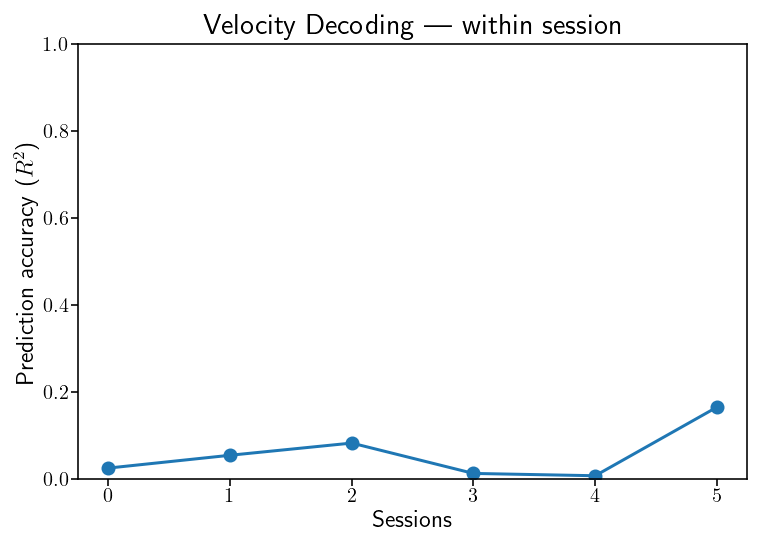

In [10]:
_,ax = plt.subplots()
ax.plot(pop_score_day,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Sessions')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- within session')

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [ ]:
pairIndex_across = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndex_across.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndex_across[-1][1].append(j)
pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

In [ ]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testId in pairIndex_across:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData,MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

normalised_across_score = []
for idx1, idx2, scores in reg_scores_across:
    across_score = np.add(*scores)/2
    animal_avg = np.mean([*animal_scores[full_list[idx1][0]], *animal_scores[full_list[idx2][0]]])
    normalised_across_score.append(across_score/animal_avg)
normalised_across_score = np.array(normalised_across_score)

In [ ]:
_,ax = plt.subplots()
ax.plot(pop_score_across,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- across animals')

In [ ]:
_,ax = plt.subplots()
ax.plot(normalised_across_score,'-o')
# ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel(r'Normalised prediction accuracy')
ax.set_title(r'Velocity Decoding: $\frac{R^2_{across}}{max(R^2_{within})}$', pad = 15)

## Without alignment

In [ ]:
warnings.filterwarnings("ignore")
reg_latent_scores = []
for id1, testId in pairIndex_across:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)

    # adding history
    AllData = dt.add_history_to_data_array(AllData,MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,2))
    AllVel1 = AllVel1.reshape((-1,2))

    # train the decoder
#     *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(X1, Y_train_x)
    reg_y.fit(X1, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(X2))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(X2))
    reg_latent_scores.append((id1,testId,(x_score,y_score)))
warnings.filterwarnings("default")

pop_latent_score = []
for _,_,scores in reg_latent_scores:
    pop_latent_score.append(np.mean(scores))
pop_latent_score = np.array(pop_latent_score)

normalised_latent_score = []
for idx1, idx2, scores in reg_latent_scores:
    across_score = np.add(*scores)/2
    animal_avg = np.mean([*animal_scores[full_list[idx1][0]], *animal_scores[full_list[idx2][0]]])
    normalised_latent_score.append(across_score/animal_avg)
normalised_latent_score = np.array(normalised_latent_score)

In [ ]:
_,ax = plt.subplots()
ax.plot(pop_latent_score,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding --- across animals without alignment')

# Universal Decoder

In [ ]:
%run "_M1-universal-decoding.ipynb"

# histograms

In [ ]:
fig,ax = plt.subplots(dpi=100)

bins = np.arange(0,1,0.05)
ax.hist(pop_score_across, bins=bins, density=True, label=r'Across monkey (\textit{aligned})', alpha=.8)
# ax.hist(pop_score2, bins=bins, density=True, label='aligned across days', alpha=.8)
ax.hist(pop_score_uni, bins=bins, density=True, label='Universal', alpha=.8)
ax.hist(pop_score_day, bins=bins, density=True, label='Within monkey', alpha=.8)
ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across monkey (\textit{unaligned})', alpha=.8)

ax.set_title('Decoding velocity --- M1')
ax.set_xlabel('Prediction accuracy ($R^2$)')
ax.set_ylabel(r'Normalised \# of sessions')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([-.05,1])
ax.legend(loc=(.2,.7))